In [166]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from copy import deepcopy # To save the best model state correctly
from torch.utils.data import TensorDataset, DataLoader

In [167]:
df = pd.read_csv('../data/probabilities.csv')


In [168]:
# Define the columns involved in determining the winner
competitor_columns = ['P(democrat|C)',
 'P(other|C)',
 'P(republican|C)',]

# Check if competitor columns exist
if not all(col in df.columns for col in competitor_columns):
    raise ValueError(f"One or more competitor columns {competitor_columns} not found in DataFrame.")


In [169]:
# Check the first few rows of the DataFrame
df.head(5)

,year,gisjoin,state,county,P(C),P(households_income_under_10k|C),P(households_income_10k_15k|C),P(households_income_15k_25k|C),P(households_income_25k_plus|C),P(persons_male|C),...,P(labor_force_civilian|C),P(labor_force_employed|C),P(labor_force_unemployed|C),P(not_in_labor_force|C),P(persons_hispanic|C),P(persons_below_poverty|C),P(democrat|C),P(other|C),P(republican|C),P(non_voter|C)
0,2008,G0100010,Alabama,Autauga County,0.000177,0.066741,0.050512,0.087433,0.795314,0.484997,...,0.469739,0.457925,0.030308,0.257643,0.023196,0.105785,0.114627,0.002728,0.327401,0.555244
1,2008,G0100030,Alabama,Baldwin County,0.000586,0.059675,0.048261,0.118775,0.773289,0.488660,...,0.456428,0.446667,0.031361,0.315852,0.038955,0.120689,0.110279,0.004301,0.348545,0.536876
2,2008,G0100050,Alabama,Barbour County,0.000092,0.173047,0.098418,0.139867,0.588668,0.528972,...,0.377342,0.357739,0.037944,0.405321,0.045958,0.223943,0.205675,0.002419,0.211777,0.580129
3,2008,G0100070,Alabama,Bibb County,0.000075,0.073512,0.073512,0.151458,0.701519,0.537904,...,0.461831,0.434277,0.043653,0.316541,0.005927,0.125166,0.101681,0.003671,0.276957,0.617691
4,2008,G0100090,Alabama,Blount County,0.000189,0.084543,0.060180,0.130114,0.725164,0.495308,...,0.451986,0.435793,0.035472,0.310802,0.074896,0.132470,0.062125,0.006280,0.359645,0.571950


## Adding a target column

In [170]:
# Create the binary target: 1 if Democrat wins, 0 otherwise
df['target_democrat_win'] = (df['P(democrat|C)'] > df['P(republican|C)']).astype(int)

y = df['target_democrat_win']
class_names = ['Republican wins', 'Democrat Win'] # For plotting/reporting
num_classes = 2 # Binary classification


In [171]:
print(f"\nTarget variable created: 'target_democrat_win' (Binary)")
print(f"Classes: {class_names}")
print(f"Value counts (0 = Republican wins, 1 = Democrat Win):\n{y.value_counts()}")
print(f"Win percentage for Democrat: {y.mean() * 100:.2f}%")



Target variable created: 'target_democrat_win' (Binary)
Classes: ['Republican wins', 'Democrat Win']
Value counts (0 = Republican wins, 1 = Democrat Win):
target_democrat_win
0    9804
1    2556
Name: count, dtype: int64
Win percentage for Democrat: 20.68%


## What this means?
From a statistical overview of the data we see that the democrats have a 20 percent win percentage. We can use NN to see how different features have resulted in this, and use it to predict how the future elections may look like.

In [172]:
# Define features (X) - Exclude identifiers and ALL competitor cols, plus the derived target/winner cols
identifier_cols = ['gisjoin', 'state', 'county']
# Keep 'year' for now, assuming it might be a useful feature
feature_cols = [col for col in df.columns if col not in identifier_cols + competitor_columns + ['year','P(democrat|C)',
       'P(other|C)', 'P(republican|C)', 'P(non_voter|C)', 'winning_category',
       'target_democrat_win']]


In [173]:
print("Number of features in the dataset:", len(feature_cols)) 

Number of features in the dataset: 111


In [174]:
X = df[feature_cols]
X.head(5)


,P(C),P(households_income_under_10k|C),P(households_income_10k_15k|C),P(households_income_15k_25k|C),P(households_income_25k_plus|C),P(persons_male|C),P(persons_female|C),P(male_never_married|C),P(male_married|C),P(male_separated|C),...,P(persons_native|C),P(persons_foreign_born|C),P(labor_force_total|C),P(labor_force_armed|C),P(labor_force_civilian|C),P(labor_force_employed|C),P(labor_force_unemployed|C),P(not_in_labor_force|C),P(persons_hispanic|C),P(persons_below_poverty|C)
0,0.000177,0.066741,0.050512,0.087433,0.795314,0.484997,0.515003,0.104468,0.222256,0.009538,...,0.980152,0.019848,0.501082,0.012849,0.469739,0.457925,0.030308,0.257643,0.023196,0.105785
1,0.000586,0.059675,0.048261,0.118775,0.773289,0.488660,0.511340,0.093799,0.248022,0.005768,...,0.963508,0.036492,0.479279,0.001251,0.456428,0.446667,0.031361,0.315852,0.038955,0.120689
2,0.000092,0.173047,0.098418,0.139867,0.588668,0.528972,0.471028,0.159067,0.201740,0.014802,...,0.971912,0.028088,0.395899,0.000217,0.377342,0.357739,0.037944,0.405321,0.045958,0.223943
3,0.000075,0.073512,0.073512,0.151458,0.701519,0.537904,0.462096,0.133348,0.243919,0.029943,...,0.993233,0.006767,0.477930,0.000000,0.461831,0.434277,0.043653,0.316541,0.005927,0.125166
4,0.000189,0.084543,0.060180,0.130114,0.725164,0.495308,0.504692,0.088408,0.245767,0.006862,...,0.952815,0.047185,0.471742,0.000476,0.451986,0.435793,0.035472,0.310802,0.074896,0.132470


## Splitting the dataset.
As explained in the ReadMe, we will split the training, validation and test set according to the election years. The training will be done on 2008 and 2016, validation will be on 2012 and test will be done on 2020. \
X = feature dataset (panda series)\
y = target dataset (panda series)

In [175]:
train_idx = (df["year"] == 2008) | (df["year"] == 2016) 

validation_idx = (df["year"] == 2012)
test_idx = (df["year"] == 2020)

In [176]:
X_train = X[train_idx]
y_train = y[train_idx]
X_val = X[validation_idx]
y_val = y[validation_idx]
X_test = X[test_idx]
y_test = y[test_idx]


In [177]:
print(f"Data split: Train shape {X_train.shape}, Test shape {X_val.shape}")
print(f"Train target distribution:{y_train.value_counts(normalize=True)}")


Data split: Train shape (6180, 111), Test shape (3090, 111)
Train target distribution:target_democrat_win
0    0.782848
1    0.217152
Name: proportion, dtype: float64


In [178]:
print(f"Validation target distribution:\n{y_val.value_counts(normalize=True)}")


Validation target distribution:
target_democrat_win
0    0.778317
1    0.221683
Name: proportion, dtype: float64


In [179]:
print(f"Test target distribution:\n{y_test.value_counts(normalize=True)}")

Test target distribution:
target_democrat_win
0    0.828803
1    0.171197
Name: proportion, dtype: float64


In [180]:

# or CUDA availability on machines with NVIDIA GPUs
device = (
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)

# Move tensor to appropriate device
device_gpu = torch.device(device)
print(f"Using device: {device}")

Using device: mps


# PyTorch Training Framework Classes

This code defines two Python classes to streamline the process of training and evaluating PyTorch neural network models, especially for binary classification.

## 1. EarlyStopping Class

*   **Usage:** Monitors a specified metric (validation loss in this case) during training and stops the training process early if the metric ceases to improve for a defined number of epochs (patience).


## 2. NeuralNetworkTrainer Class

*   **Purpose:** Encapsulates the common steps involved in training a PyTorch model, making the training process reusable and organized.
*   **Initialization (__init__)**:
    *   Takes a PyTorch model (nn.Module), a criterion (loss function), optimizer_class, optimizer_params (like learning rate), target device (mps in this case), and patience for early stopping.
    *   Moves the model to gpu
    *   Initializes the optimizer and the EarlyStopping instance.
*   **Data Preparation (_prepare_data)**:
    *   Creates TensorDataset and DataLoader objects for batching and shuffling training data.
*   **Training (train)**:
    *   The main method to start the training process.
    *   Takes training data (X_tr, y_tr), validation data (X_val, y_val), number of epochs, and batch_size.
    *   Loads the best model state found during training after the loop finishes or early stopping occurs.
    *   Returns a dictionary containing training/validation history.
*   **Evaluation (evaluate)**:
    *   Calculates loss and accuracy on a provided DataLoader created using _prepare_data.
    *   Returns average loss and accuracy.
*   **Prediction (predict)**:
    *   Takes new input data (X_test as NumPy array).
    *   Performs inference using the trained model.
    *   Returns binary predictions (>= 0.5 threshold) as a NumPy array.
*   **Helper Methods (get_model, get_history)**: Provide access to the final model instance and the collected training metrics.

In [181]:
# --- Early Stopping Class (can be kept separate or nested) ---
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 10
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                           Default: 0
            path (str): Path for the checkpoint to be saved to.
                        Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                                   Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                # Load the best model state before stopping
                if self.best_model_state:
                     model.load_state_dict(self.best_model_state)
                     if self.verbose:
                         self.trace_func('Loaded best model state due to early stopping.')
                else:
                     if self.verbose:
                         self.trace_func('Warning: Early stopping triggered but no best model state was saved.')

        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        # Use deepcopy to ensure the state dict is not a reference that changes later
        self.best_model_state = deepcopy(model.state_dict())
        # Optionally save to disk as well
        # torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# --- Main Trainer Class ---
class NeuralNetworkTrainer:
    def __init__(self, model, criterion, optimizer_class, optimizer_params, device = device_gpu, patience=10):
        """
        Initializes the Neural Network Trainer.

        Args:
            model (nn.Module): The neural network model instance.
            criterion: The loss function (e.g., nn.BCELoss()).
            optimizer_class: The optimizer class (e.g., optim.Adam).
            optimizer_params (dict): Parameters for the optimizer (e.g., {'lr': 0.001}).
            device (torch.device): The device to run training on ('cuda' or 'cpu').
            patience (int): Patience for early stopping. Default: 10.
        """
        self.device = device
        self.model = model.to(self.device)
        self.criterion = criterion
        # Ensure optimizer is initialized with the model parameters *after* moving to device
        self.optimizer = optimizer_class(self.model.parameters(), **optimizer_params)
        self.early_stopping = EarlyStopping(patience=patience, verbose=True)
        self.train_loss_history = []
        self.val_loss_history = []
        self.val_accuracy_history = []

        print(f"Trainer initialized on device: {self.device}")
        print("Model Architecture:")
        print(self.model)

    def _prepare_data(self, X_tr, y_tr_vals, X_val, y_val_vals, batch_size):
        """Converts data to tensors, moves to device, and creates DataLoaders."""
        # --- Convert data ---

        X_tr_tensor = torch.FloatTensor(X_tr).to(self.device)
        y_tr_tensor = torch.FloatTensor(y_tr_vals).unsqueeze(1).to(self.device) # Ensure y is [N, 1] for BCELoss
        X_val_tensor = torch.FloatTensor(X_val).to(self.device)
        y_val_tensor = torch.FloatTensor(y_val_vals).unsqueeze(1).to(self.device) # Ensure y is [N, 1] for BCELoss

        # --- Create DataLoaders ---
        train_dataset = TensorDataset(X_tr_tensor, y_tr_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        # Keep batch_size for validation loader consistent or potentially larger
        # No need to shuffle validation data
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        print(f"Data prepared: Train batches={len(train_loader)}, Val batches={len(val_loader)}")
        # Store tensors for potential full-dataset evaluation if needed, though loader is preferred
        self.X_val_tensor = X_val_tensor
        self.y_val_tensor = y_val_tensor

        return train_loader, val_loader

    def train(self, X_tr, y_tr, X_val, y_val, epochs=35, batch_size=64):
        """
        Trains the neural network model.

        Args:
            X_tr: Training features (e.g., scaled NumPy array).
            y_tr: Training labels/targets (e.g., NumPy array or Pandas Series).
            X_val: Validation features.
            y_val: Validation labels/targets.
            epochs (int): Number of training epochs. Default: 35.
            batch_size (int): Batch size for training and validation. Default: 64.

        Returns:
            dict: A dictionary containing training history (losses and accuracy).
        """
        # Reset histories for a new training run
        self.train_loss_history = []
        self.val_loss_history = []
        self.val_accuracy_history = []

        train_loader, val_loader = self._prepare_data(X_tr, y_tr, X_val, y_val, batch_size)

        print(f"\n--- Starting Training for {epochs} epochs ---")
        for epoch in range(epochs):
            # --- Training Phase ---
            self.model.train()
            total_train_loss = 0
            for X_batch, y_batch in train_loader:
                # Data already on the correct device from _prepare_data
                self.optimizer.zero_grad()
                outputs = self.model(X_batch) # Output shape should be [batch_size, 1]
                loss = self.criterion(outputs, y_batch) # BCELoss expects [N, *] and [N, *]
                loss.backward()
                self.optimizer.step()
                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            self.train_loss_history.append(avg_train_loss)

            # --- Validation Phase ---
            avg_val_loss, avg_val_accuracy = self.evaluate(val_loader, print_metrics=False)
            self.val_loss_history.append(avg_val_loss)
            self.val_accuracy_history.append(avg_val_accuracy)

            # --- Logging ---
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_accuracy:.4f}")

            # --- Early Stopping Check ---
            self.early_stopping(avg_val_loss, self.model)
            if self.early_stopping.early_stop:
                print("Early stopping triggered.")
                # The best model state is already loaded by EarlyStopping class
                break

        print("--- Model training finished. ---")
        # Ensure the model loaded is the best one found during early stopping
        if self.early_stopping.best_model_state:
             self.model.load_state_dict(self.early_stopping.best_model_state)
             print("Loaded best model state based on validation loss.")

        return {
            'train_loss': self.train_loss_history,
            'val_loss': self.val_loss_history,
            'val_accuracy': self.val_accuracy_history
        }

    def evaluate(self, data_loader, print_metrics=True):
        """
        Evaluates the model on a given DataLoader.

        Args:
            data_loader (DataLoader): DataLoader containing the dataset to evaluate.
            print_metrics (bool): Whether to print the final loss and accuracy. Default: True.

        Returns:
            tuple: Average loss and average accuracy.
        """
        self.model.eval()  # Set model to evaluation mode
        total_loss = 0
        total_correct = 0
        total_samples = 0

        with torch.no_grad(): # Disable gradient calculations
            for X_batch, y_batch in data_loader:
                # Data should already be on the correct device
                outputs = self.model(X_batch) # Shape [batch_size, 1]
                loss = self.criterion(outputs, y_batch) # Use the same criterion
                total_loss += loss.item() * X_batch.size(0) # Accumulate weighted loss

                # Calculate accuracy for binary classification
                predicted = (outputs >= 0.5).float() # Threshold sigmoid output
                total_correct += (predicted == y_batch).sum().item()
                total_samples += y_batch.size(0)

        avg_loss = total_loss / total_samples if total_samples > 0 else 0
        avg_accuracy = total_correct / total_samples if total_samples > 0 else 0

        if print_metrics:
            print(f"\n--- Evaluation Results ---")
            print(f"Average Loss: {avg_loss:.4f}")
            print(f"Accuracy: {avg_accuracy:.4f} ({total_correct}/{total_samples})")

        return avg_loss, avg_accuracy

    def predict(self, X_test):
        """Makes predictions on new data."""
        self.model.eval()
        X_test_tensor = torch.FloatTensor(X_test).to(self.device)
        with torch.no_grad():
            outputs = self.model(X_test_tensor)
            predictions = (outputs >= 0.5).float() # Threshold for binary classification
        return predictions.cpu().numpy() # Return as NumPy array on CPU

    def get_model(self):
        """Returns the current model instance."""
        return self.model

    def get_history(self):
         """Returns the training history."""
         return {
            'train_loss': self.train_loss_history,
            'val_loss': self.val_loss_history,
            'val_accuracy': self.val_accuracy_history
         }


In [182]:
# Fit scaler on training data only
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_train)

# Transform validation and test sets using training parameters
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#labels
y_train_val = y_train.values.astype(np.float32) # Ensure y is float32 for BCELoss
y_val_vals = y_val.values.astype(np.float32) # Ensure y is float32 for BCELoss

# 2. Configuration used in all models.
input_dim = X_tr_scaled.shape[1] # Get input dim from data
learning_rate = 0.001
epochs_to_run = 50
batch_s = 64
patience_early_stop = 10

In [ ]:

# --- Example Usage ---

# 0. Define your custom model architecture (or use the existing one)
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid() # Output is a single probability
        )

    def forward(self, x):
        return self.net(x)


# 3. Instantiate the Model
model_instance = BinaryClassifier(input_dim)

# 4. Instantiate the Trainer
trainer = NeuralNetworkTrainer(
    model=model_instance,
    criterion=nn.BCELoss(),           # Binary Cross-Entropy for binary classification
    optimizer_class=optim.Adam,       # Using Adam optimizer
    optimizer_params={'lr': learning_rate},  
    device=device,
    patience=patience_early_stop
)

# 5. Train the model
history = trainer.train(
    X_tr=X_tr_scaled,
    y_tr=y_train_val,
    X_val=X_val_scaled,
    y_val=y_val_vals,
    epochs=epochs_to_run,
    batch_size=batch_s
)

# 6. Evaluate the final (best) model on the validation set again
print("\n--- Final Evaluation on Validation Set ---")
# Recreate val_loader or use the one implicitly created in train/evaluate
_, val_loader = trainer._prepare_data(X_tr_scaled, y_train_val, X_val_scaled, y_val_vals, batch_s) # Need to recreate or store it
final_loss, final_accuracy = trainer.evaluate(val_loader) # Use the evaluate method

# 7. Get the trained model if needed
final_3NN_model = trainer
_3NN_train_loss = trainer.get_history()['train_loss']
_3NN_val_loss = trainer.get_history()['val_loss']
# 8. Get training history

# 9. Make predictions on new data (Example)
# X_new_data = np.random.rand(5, input_dim).astype(np.float32)
# predictions = trainer.predict(X_new_data)
# print("\nPredictions on new data:", predictions)

Trainer initialized on device: mps
Model Architecture:
BinaryClassifier(
  (net): Sequential(
    (0): Linear(in_features=111, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Data prepared: Train batches=97, Val batches=49

--- Starting Training for 50 epochs ---
Epoch 1/50 | Train Loss: 0.4145 | Val Loss: 0.3080 | Val Acc: 0.8764
Validation loss decreased (inf --> 0.308017). Saving model ...
Epoch 2/50 | Train Loss: 0.2886 | Val Loss: 0.2757 | Val Acc: 0.8893
Validation loss decreased (0.308017 --> 0.275655). Saving model ...
Epoch 3/50 | Train Loss: 0.2568 | Val Loss: 0.2806 | Val Acc: 0.8841
EarlyStopping counter: 1 out of 10
Epoch 4/50 | Train Loss: 0.2402 | Val Loss: 0.2573 | Val Acc: 0.8874
Validation loss decreased (0.275655 --> 0.257329). Saving 

In [184]:
# --- 1. Define the 2-Layer Model ---
class BinaryClassifier2Layer(nn.Module): # Renamed for clarity
    def __init__(self, input_dim):
        super(BinaryClassifier2Layer, self).__init__()
        # Using nn.Sequential makes the forward pass simpler
        self.layer = nn.Sequential(
            nn.Linear(input_dim, 64),  # Linear layer: input_dim -> 64
            nn.ReLU(),                 # ReLU activation function
            nn.Dropout(0.3),           # Dropout layer with 30% dropout rate
            nn.Linear(64, 1),          # Linear layer: 64 -> 1 (single output)
            nn.Sigmoid()               # Sigmoid activation for binary classification
        )

    def forward(self, x):
        # The forward pass is handled by nn.Sequential
        return self.layer(x)
    
model_instance = BinaryClassifier2Layer(input_dim)

# 4. Instantiate the Trainer
trainer = NeuralNetworkTrainer(
    model=model_instance,
    criterion=nn.BCELoss(),           # Binary Cross-Entropy for binary classification
    optimizer_class=optim.Adam,       # Using Adam optimizer
    optimizer_params={'lr': learning_rate}, # Pass learning rate here
    device=device,
    patience=patience_early_stop
)

# 5. Train the model
history = trainer.train(
    X_tr=X_tr_scaled,
    y_tr=y_train_val,
    X_val=X_val_scaled,
    y_val=y_val_vals,
    epochs=epochs_to_run,
    batch_size=batch_s
)

# 6. Evaluate the final (best) model on the validation set again
print("\n--- Final Evaluation on Validation Set ---")
# Recreate val_loader or use the one implicitly created in train/evaluate
_, val_loader = trainer._prepare_data(X_tr_scaled, y_train_val, X_val_scaled, y_val_vals, batch_s) # Need to recreate or store it
final_loss, final_accuracy = trainer.evaluate(val_loader) # Use the evaluate method

# 7. Get the trained model if needed
final_2NN_model = trainer
_2NN_train_loss = trainer.get_history()['train_loss']
_2NN_val_loss = trainer.get_history()['val_loss']
# 8. Get training history


Trainer initialized on device: mps
Model Architecture:
BinaryClassifier2Layer(
  (layer): Sequential(
    (0): Linear(in_features=111, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
    (4): Sigmoid()
  )
)
Data prepared: Train batches=97, Val batches=49

--- Starting Training for 50 epochs ---
Epoch 1/50 | Train Loss: 0.4311 | Val Loss: 0.3609 | Val Acc: 0.8625
Validation loss decreased (inf --> 0.360948). Saving model ...
Epoch 2/50 | Train Loss: 0.3169 | Val Loss: 0.3190 | Val Acc: 0.8731
Validation loss decreased (0.360948 --> 0.318955). Saving model ...
Epoch 3/50 | Train Loss: 0.2822 | Val Loss: 0.2966 | Val Acc: 0.8822
Validation loss decreased (0.318955 --> 0.296626). Saving model ...
Epoch 4/50 | Train Loss: 0.2653 | Val Loss: 0.2895 | Val Acc: 0.8803
Validation loss decreased (0.296626 --> 0.289477). Saving model ...
Epoch 5/50 | Train Loss: 0.2540 | Val Loss: 0.2795 | Val Acc: 0.88

In [185]:
class logisticClassifier(nn.Module):
    def __init__(self, input_dim):
        super(logisticClassifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, 1),  # Linear layer to map input to a single output
            nn.Sigmoid()  # Logistic regression: linear layer + sigmoid activation
        )

    def forward(self, x):
        return self.layer(x)

model_instance = logisticClassifier(input_dim)

# 4. Instantiate the Trainer
trainer = NeuralNetworkTrainer(
    model=model_instance,
    criterion=nn.BCELoss(),           # Binary Cross-Entropy for binary classification
    optimizer_class=optim.Adam,       # Using Adam optimizer
    optimizer_params={'lr': learning_rate}, # Pass learning rate here
    device=device,
    patience=patience_early_stop
)

# 5. Train the model
history = trainer.train(
    X_tr=X_tr_scaled,
    y_tr=y_train_val,
    X_val=X_val_scaled,
    y_val=y_val_vals,
    epochs=epochs_to_run,
    batch_size=batch_s
)

# 6. Evaluate the final (best) model on the validation set again
print("\n--- Final Evaluation on Validation Set ---")
# Recreate val_loader or use the one implicitly created in train/evaluate
_, val_loader = trainer._prepare_data(X_tr_scaled, y_train_val, X_val_scaled, y_val_vals, batch_s) # Need to recreate or store it
final_loss, final_accuracy = trainer.evaluate(val_loader) # Use the evaluate method

# 7. Get the trained model if needed
logistic_model = trainer
logistic_train_loss = trainer.get_history()['train_loss']
logistic_val_loss = trainer.get_history()['val_loss']
# 8. Get training history


Trainer initialized on device: mps
Model Architecture:
logisticClassifier(
  (layer): Sequential(
    (0): Linear(in_features=111, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
Data prepared: Train batches=97, Val batches=49

--- Starting Training for 50 epochs ---
Epoch 1/50 | Train Loss: 0.5838 | Val Loss: 0.5477 | Val Acc: 0.7492
Validation loss decreased (inf --> 0.547745). Saving model ...
Epoch 2/50 | Train Loss: 0.5152 | Val Loss: 0.5145 | Val Acc: 0.7744
Validation loss decreased (0.547745 --> 0.514538). Saving model ...
Epoch 3/50 | Train Loss: 0.4762 | Val Loss: 0.4912 | Val Acc: 0.7896
Validation loss decreased (0.514538 --> 0.491169). Saving model ...
Epoch 4/50 | Train Loss: 0.4474 | Val Loss: 0.4720 | Val Acc: 0.8023
Validation loss decreased (0.491169 --> 0.472025). Saving model ...
Epoch 5/50 | Train Loss: 0.4252 | Val Loss: 0.4558 | Val Acc: 0.8146
Validation loss decreased (0.472025 --> 0.455789). Saving model ...
Epoch 6/50 | Train Loss: 0.4065 | Val Loss: 0.44

In [186]:
# --- 3. Model Definition ---
# Define a simple linear regression model using PyTorch's nn.Module
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        # Initialize the parent class (nn.Module)
        super(LinearRegressionModel, self).__init__()
        # Define a single linear layer that maps input_dim features to 1 output feature
        # This layer will learn the weights and bias for the linear regression equation.
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        # Define the forward pass: simply pass the input through the linear layer
        # This calculates the prediction: y = Wx + b
        return self.linear(x)

model_instance = LinearRegressionModel(input_dim)

# 4. Instantiate the Trainer
trainer = NeuralNetworkTrainer(
    model=model_instance,
    criterion=nn.BCELoss(),           # Binary Cross-Entropy for binary classification
    optimizer_class=optim.Adam,       # Using Adam optimizer
    optimizer_params={'lr': learning_rate}, # Pass learning rate here
    device=device,
    patience=patience_early_stop
)

# 5. Train the model
history = trainer.train(
    X_tr=X_tr_scaled,
    y_tr=y_train_val,
    X_val=X_val_scaled,
    y_val=y_val_vals,
    epochs=epochs_to_run,
    batch_size=batch_s
)

# 6. Evaluate the final (best) model on the validation set again
print("\n--- Final Evaluation on Validation Set ---")
# Recreate val_loader or use the one implicitly created in train/evaluate
_, val_loader = trainer._prepare_data(X_tr_scaled, y_train_val, X_val_scaled, y_val_vals, batch_s) # Need to recreate or store it
final_loss, final_accuracy = trainer.evaluate(val_loader) # Use the evaluate method

# 7. Get the trained model if needed
linear_model = trainer
linear_train_loss = trainer.get_history()['train_loss']
linear_val_loss = trainer.get_history()['val_loss']
# 8. Get training history


Trainer initialized on device: mps
Model Architecture:
LinearRegressionModel(
  (linear): Linear(in_features=111, out_features=1, bias=True)
)
Data prepared: Train batches=97, Val batches=49

--- Starting Training for 50 epochs ---
Epoch 1/50 | Train Loss: 6.8838 | Val Loss: 2.7490 | Val Acc: 0.7741
Validation loss decreased (inf --> 2.748963). Saving model ...
Epoch 2/50 | Train Loss: 2.7605 | Val Loss: 1.1201 | Val Acc: 0.7773
Validation loss decreased (2.748963 --> 1.120071). Saving model ...
Epoch 3/50 | Train Loss: 1.3621 | Val Loss: 0.7669 | Val Acc: 0.7809
Validation loss decreased (1.120071 --> 0.766932). Saving model ...
Epoch 4/50 | Train Loss: 0.9029 | Val Loss: 0.7331 | Val Acc: 0.7790
Validation loss decreased (0.766932 --> 0.733073). Saving model ...
Epoch 5/50 | Train Loss: 0.6482 | Val Loss: 0.5988 | Val Acc: 0.7809
Validation loss decreased (0.733073 --> 0.598838). Saving model ...
Epoch 6/50 | Train Loss: 0.6517 | Val Loss: 0.4965 | Val Acc: 0.7819
Validation loss dec

## Comparing the 4 models
Our 4 models = final_3NN_model, logistic_model, linear_model, final_2NN_model\
We can now evaluate these models on the test set that we had made before.


--- Confusion Matrix and Classification Report for 3 layer NN ---

Classification Report:
                 precision    recall  f1-score   support

Republican wins       0.93      0.99      0.96      2561
   Democrat Win       0.91      0.64      0.75       529

       accuracy                           0.93      3090
      macro avg       0.92      0.81      0.85      3090
   weighted avg       0.93      0.93      0.92      3090


--- Training History for 3 layer NN ---

--- Confusion Matrix and Classification Report for 2 layer NN ---

Classification Report:
                 precision    recall  f1-score   support

Republican wins       0.94      0.98      0.96      2561
   Democrat Win       0.89      0.69      0.78       529

       accuracy                           0.93      3090
      macro avg       0.91      0.84      0.87      3090
   weighted avg       0.93      0.93      0.93      3090


--- Training History for 2 layer NN ---

--- Confusion Matrix and Classification Repor

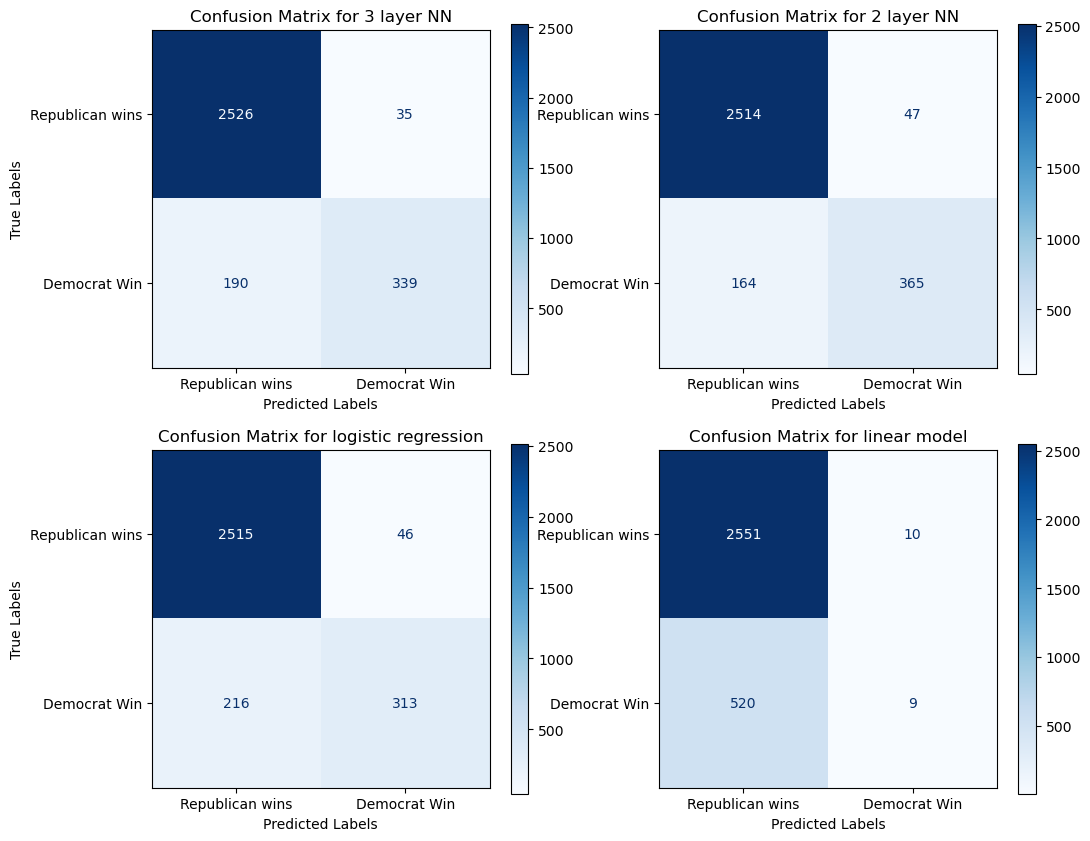

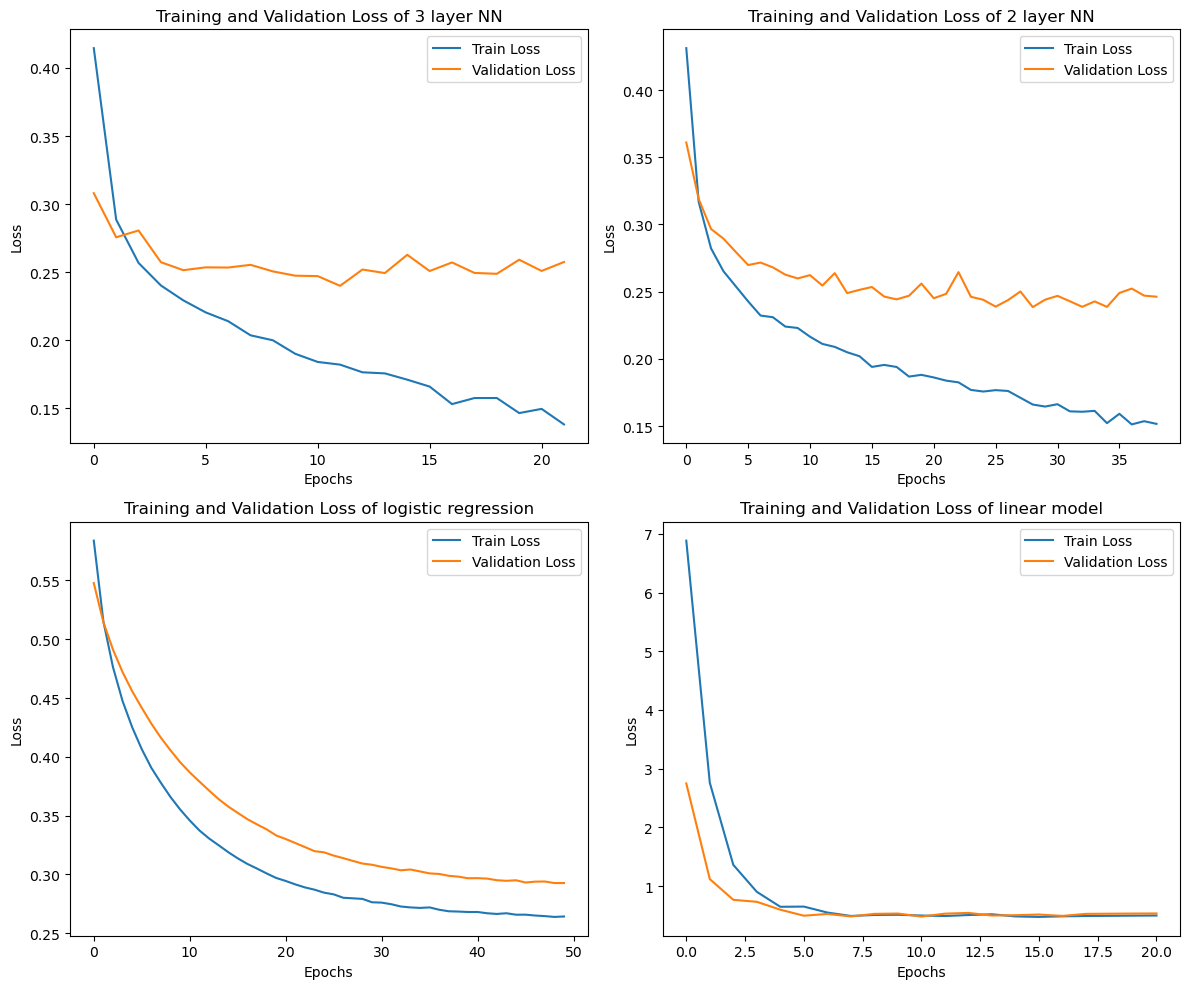

In [187]:
# Corrected CMplotting class
class CMplotting:
    def __init__(self, model, X_val, y_val, class_names):
        self.model = model
        self.X_val = X_val
        self.y_val = y_val
        self.class_names = class_names

    def plot_confusion_matrix(self, ax, names):
        # Make predictions
        y_pred = self.model.predict(self.X_val)
        
        # Compute confusion matrix
        cm = confusion_matrix(self.y_val, y_pred)
        
        # Plot confusion matrix on the provided axis
        cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.class_names)
        cm_display.plot(cmap=plt.cm.Blues, ax=ax)
        ax.set_title('Confusion Matrix for ' + names)
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')

    def print_classification_report(self):
        # Make predictions
        y_pred = self.model.predict(self.X_val)
        
        # Get classification report as a dictionary
        report = classification_report(self.y_val, y_pred, target_names=self.class_names, output_dict=True)
        
        # Print the classification report
        print("\nClassification Report:")
        print(classification_report(self.y_val, y_pred, target_names=self.class_names))
        return report

    def plot_training_history(self, ax, name):
        # Plot training history
        ax.plot(self.model.get_history()['train_loss'], label='Train Loss')
        ax.plot(self.model.get_history()['val_loss'], label='Validation Loss')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.set_title('Training and Validation Loss of'+ ' ' + name)
        ax.legend()

# Plot confusion matrices for all models
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid of subplots
fig2, axs2 = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid of subplots
models = [final_3NN_model, final_2NN_model, logistic_model, linear_model]
names = ["3 layer NN", "2 layer NN", "logistic regression", "linear model"]  # List of models

for ax, ax2, model, name in zip(axs.ravel(), axs2.ravel(), models, names):  # Iterate through axes and models
    print(f"\n--- Confusion Matrix and Classification Report for {name} ---")
    cm_plotter = CMplotting(model, X_test_scaled, y_test, class_names)
    cm_plotter.plot_confusion_matrix(ax, name)  # Plot confusion matrix on the current axis
    x = cm_plotter.print_classification_report() # Print classification report for the current model
    print(f"\n--- Training History for {name} ---")
    cm_plotter.plot_training_history(ax2, name)  # Plot training history on the current axis
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [189]:
x

{'Republican wins': {'precision': 0.9300441826215022,
  'recall': 0.9863334634908238,
  'f1-score': 0.9573621375781695,
  'support': 2561.0},
 'Democrat Win': {'precision': 0.9064171122994652,
  'recall': 0.6408317580340265,
  'f1-score': 0.7508305647840532,
  'support': 529.0},
 'accuracy': 0.9271844660194175,
 'macro avg': {'precision': 0.9182306474604838,
  'recall': 0.8135826107624251,
  'f1-score': 0.8540963511811113,
  'support': 3090.0},
 'weighted avg': {'precision': 0.9259992893527781,
  'recall': 0.9271844660194175,
  'f1-score': 0.9220044670253903,
  'support': 3090.0}}

In [191]:
# make a summary table of the models
repub_win_f1 = []
dem_win_f1 = []
macro_f1 = []
for model in models:
    cm_plotter = CMplotting(model, X_test_scaled, y_test, class_names)
    x = cm_plotter.print_classification_report()
    repub_win_f1.append(x['Republican wins']['f1-score'])
    dem_win_f1.append(x['Democrat Win']['f1-score'])
    macro_f1.append(x['macro avg']['f1-score'])


summary_table = pd.DataFrame({
    'Model': names,
    'Mean train Loss': [np.mean(model.get_history()['train_loss']) for model in models],
    'Mean validation Loss': [np.mean(model.get_history()['val_loss']) for model in models],
    'Validation Accuracy': [model.evaluate(model._prepare_data(X_tr_scaled, y_train_val, X_val_scaled, y_val_vals, batch_s)[1])[1] for model in models],
    "F1 score Republic wins": repub_win_f1,
    'F1 score Democrat wins': dem_win_f1,
    'macro avg F1 score': macro_f1
})
print("\nSummary Table of Models:")


Classification Report:
                 precision    recall  f1-score   support

Republican wins       0.93      0.99      0.96      2561
   Democrat Win       0.91      0.64      0.75       529

       accuracy                           0.93      3090
      macro avg       0.92      0.81      0.85      3090
   weighted avg       0.93      0.93      0.92      3090


Classification Report:
                 precision    recall  f1-score   support

Republican wins       0.94      0.98      0.96      2561
   Democrat Win       0.89      0.69      0.78       529

       accuracy                           0.93      3090
      macro avg       0.91      0.84      0.87      3090
   weighted avg       0.93      0.93      0.93      3090


Classification Report:
                 precision    recall  f1-score   support

Republican wins       0.92      0.98      0.95      2561
   Democrat Win       0.87      0.59      0.70       529

       accuracy                           0.92      3090
      ma

In [192]:

summary_table


,Model,Mean train Loss,Mean validation Loss,Validation Accuracy,F1 score Republic wins,F1 score Democrat wins,macro avg F1 score
0,3 layer NN,0.200732,0.257216,0.903560,0.957362,0.750831,0.854096
1,2 layer NN,0.202092,0.258299,0.903883,0.959725,0.775770,0.867748
2,logistic regression,0.314874,0.345587,0.877346,0.950491,0.704955,0.827723
3,linear model,0.986631,0.677729,0.783495,0.905895,0.032847,0.469371


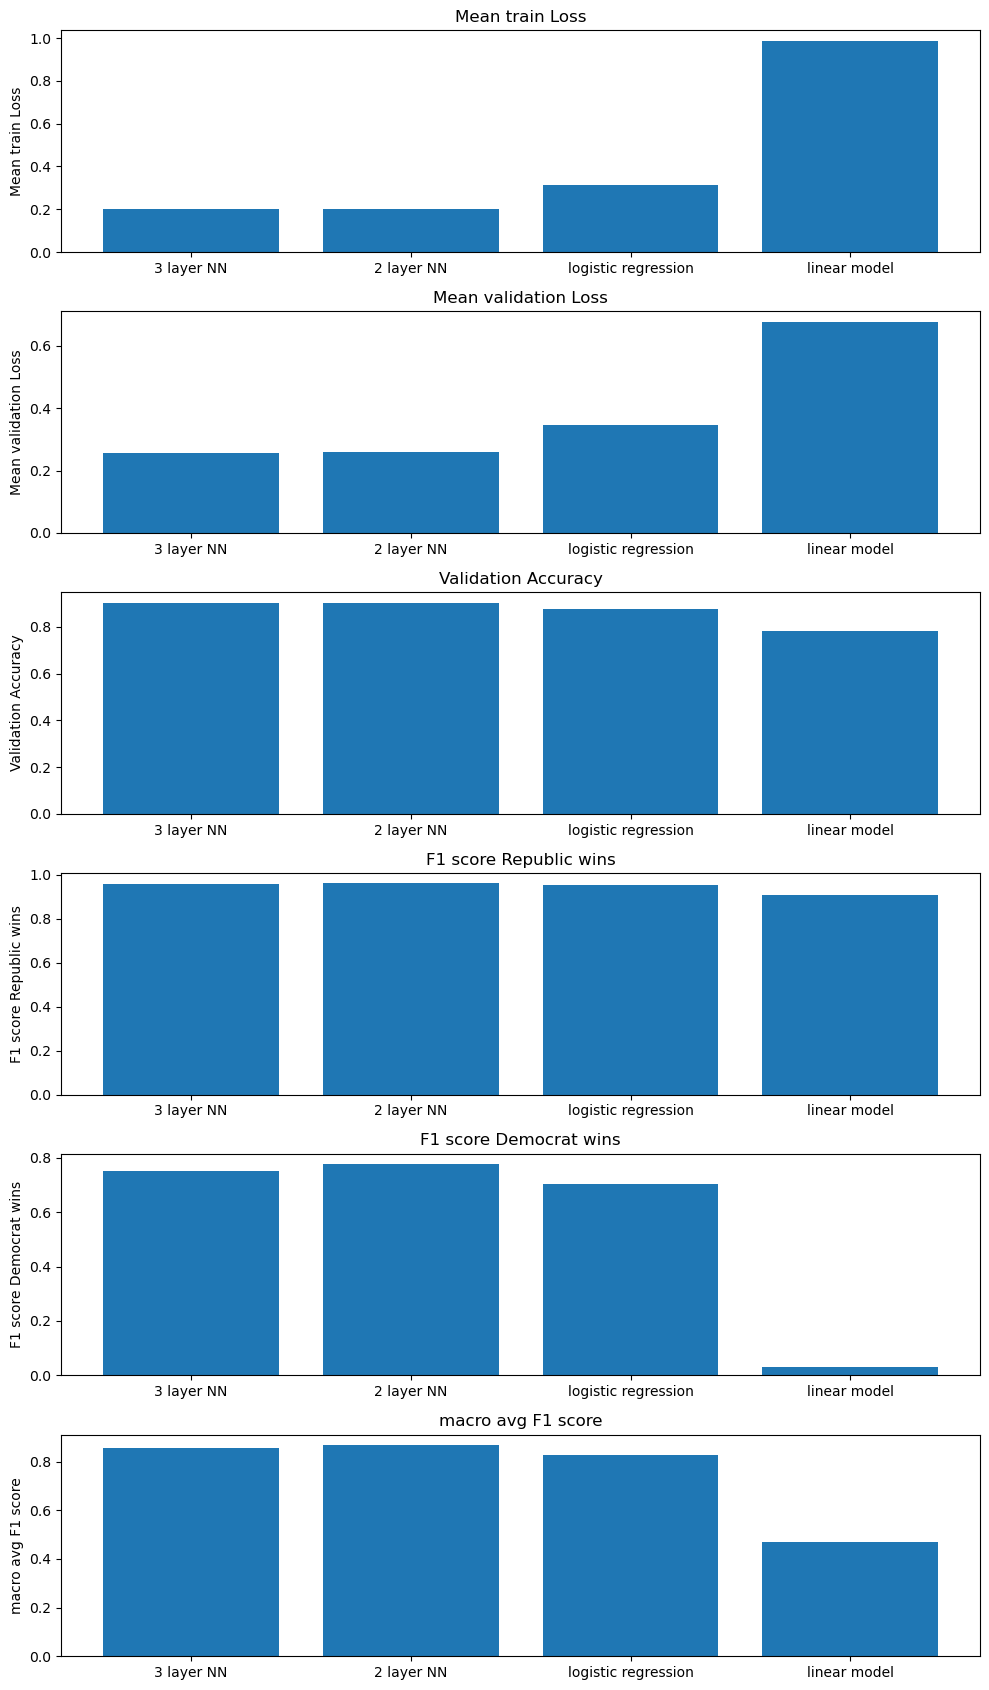

In [193]:
#Histograms of the summary table, x axis are the model names
fig, axs = plt.subplots(6, figsize=(10, 17))  # Create a 2x2 grid of subplots
for ax, col in zip(axs.ravel(), summary_table.columns[1:]):
    ax.bar(summary_table['Model'], summary_table[col])
    ax.set_title(col)
    ax.set_ylabel(col)
    ax.set_xticks(range(len(summary_table['Model'])))
    ax.set_xticklabels(summary_table['Model'], rotation=0)
plt.tight_layout()  # Adjust layout to prevent overlap

## General take aways

# 3 layer Neural Network 
 - Best F1 scores 
 - Lowest train loss
 - Better prediction

# 2 layer Neural Network
 - Comparable to 3 layered 
 - Has a better macro avg f1-score

# logistic regression
 - Has a slightly worse F1 score for democratic wins and therfore the validation accuracy
 - But most metrics are similar to past two

# linear regression
 - Trash
